Modélisation GARCH pour la prévision de volatilité financière
Données: S&P 500 (GSPC) et Bitcoin (BTCUSD)

In [2]:
pip install arch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

CHARGEMENT ET PRÉPARATION DES DONNÉES

In [6]:
import os
os.chdir('C:/Users/mtaka/volatility-forecasting-garch-lstm')

In [8]:
spx_data = pd.read_csv('data/sample/GSPC_sample.csv')
spx_data['date'] = pd.to_datetime(spx_data['date'])
spx_data = spx_data.sort_values('date').reset_index(drop=True)

btc_data = pd.read_csv('data/sample/BTC-USD_sample.csv')
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_data = btc_data.sort_values('date').reset_index(drop=True)

print("OK données chargées")
print("S&P 500:", len(spx_data), "obs")
print("Bitcoin:", len(btc_data), "obs")


OK données chargées
S&P 500: 1742 obs
Bitcoin: 2538 obs


RÉCUPÉRER LES RENDEMENTS

In [9]:
spx_returns = spx_data['log_return'].dropna()
btc_returns = btc_data['log_return'].dropna()

print("\nS&P 500 rendements:")
print("Moyenne:", spx_returns.mean())
print("Écart-type:", spx_returns.std())

print("\nBitcoin rendements:")
print("Moyenne:", btc_returns.mean())
print("Écart-type:", btc_returns.std())


S&P 500 rendements:
Moyenne: 0.0004217321784314849
Écart-type: 0.012525264833494403

Bitcoin rendements:
Moyenne: 0.0007804645859572838
Écart-type: 0.035257165262824276


GARCH(1,1) - S&P 500

In [10]:
print("\n" + "="*50)
print("GARCH S&P 500")
print("="*50)

model_spx = arch_model(spx_returns, vol='Garch', p=1, q=1)
result_spx = model_spx.fit(disp='off')
print(result_spx.summary())



GARCH S&P 500
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5585.39
Distribution:                  Normal   AIC:                          -11162.8
Method:            Maximum Likelihood   BIC:                          -11140.9
                                        No. Observations:                 1741
Date:                Thu, Dec 11 2025   Df Residuals:                     1740
Time:                        21:38:11   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.2295e-04  2.093e-04      3.932

##### Interprétation

Paramètres clés

**ω (omega) = 0.00000356**
- C'est la volatilité de base du marché
- Très petite, normal pour un indice stable comme le S&P 500

**α (alpha) = 0.2002**
- Les chocs passés impactent 20% de la volatilité actuelle
- Quand il y a une grosse journée en bourse, ça affecte un peu la volatilité d'après

**β (beta) = 0.7801**
- 78% de la volatilité d'hier reste aujourd'hui
- La volatilité "persiste" longtemps (elle change lentement)

 Ce que ça veut dire

α + β = 0.2002 + 0.7801 = **0.9803** (presque 1!)

→ **La volatilité du S&P 500 est très stable et prévisible**

Quand le marché bouge beaucoup un jour, ce mouvement continue à influencer les jours suivants mais doucement. C'est logique pour un indice large et diversifié.
 
Qualité du modèle

- Log-Likelihood: 5585.39 (bon ajustement)
- 1741 observations
- Les résidus sont bien distribués (Normal)

GARCH(1,1) - BITCOIN

In [11]:
print("\n" + "="*50)
print("GARCH BITCOIN")
print("="*50)

model_btc = arch_model(btc_returns, vol='Garch', p=1, q=1)
result_btc = model_btc.fit(disp='off')
print(result_btc.summary())


GARCH BITCOIN
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5018.04
Distribution:                  Normal   AIC:                          -10028.1
Method:            Maximum Likelihood   BIC:                          -10004.7
                                        No. Observations:                 2537
Date:                Thu, Dec 11 2025   Df Residuals:                     2536
Time:                        21:38:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4147e-03  6.444e-04      2.195

##### Interprétation
Paramètres clés
**ω (omega) = 0.0001242**

Volatilité de base beaucoup plus élevée qu'le S&P 500
Bitcoin est un actif beaucoup plus volatil!

**α (alpha) = 0.1000**

Les chocs passés impactent seulement 10% de la volatilité
Bitcoin répond moins aux chocs récents que le S&P 500

**β (beta) = 0.8000**

80% de la volatilité d'hier reste aujourd'hui
Même persistance que le S&P 500 (très stable)

→ Ce que ça veut dire
α + β = 0.1000 + 0.8000 = 0.9000
**→ Bitcoin a une volatilité de base plus haute MAIS elle change moins vite.**
Bitcoin est naturellement plus chaotique (ω plus grand) mais une fois que la volatilité est établie, elle reste stable. C'est l'inverse du S&P 500 qui a peu de volatilité de base mais réagit plus aux chocs.

Qualité du modèle
  Log-Likelihood: 5018.04 (moins bon qu'S&P 500)
  2537 observations
  Les résidus sont bien distribués

EGARCH - S&P 500

In [12]:
print("\n" + "="*50)
print("EGARCH S&P 500")
print("="*50)

model_egarch_spx = arch_model(spx_returns, vol='EGarch', p=1, q=1)
result_egarch_spx = model_egarch_spx.fit(disp='off')
print(result_egarch_spx.summary())


EGARCH S&P 500
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5581.52
Distribution:                  Normal   AIC:                          -11155.0
Method:            Maximum Likelihood   BIC:                          -11133.2
                                        No. Observations:                 1741
Date:                Thu, Dec 11 2025   Df Residuals:                     1740
Time:                        21:39:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.9611e-04  2.051e-04      4.85

##### Interprétation
Paramètres clés
**ω (omega) = -0.4809 (négatif!)**

Paramètre de base pour la volatilité exponentielle
En EGARCH, ω peut être négatif (formulation log différente)

**α (alpha) = 0.3313**

Impact des chocs passés (un peu plus haut qu'le GARCH simple)
EGARCH capture mieux l'effet des chocs

**β (beta) = 0.9464**

Persistance très élevée (94.64%)
La volatilité change encore plus lentement qu'en GARCH simple

→ Ce que ça veut dire
EGARCH vs GARCH:

Log-Likelihood: 5581.52 (légèrement moins bon que GARCH)
EGARCH capture l'asymétrie: les chocs négatifs et positifs n'ont pas le même impact
Mais pour le S&P 500, le GARCH simple suffit (pas beaucoup d'asymétrie)

*Conclusion:*
*Le S&P 500 n'a pas vraiment d'effet levier (asymétrie). Un GARCH simple marche mieux qu'un EGARCH pour cet indice.*

EGARCH - BITCOIN

In [13]:
print("\n" + "="*50)
print("EGARCH BITCOIN")
print("="*50)

model_egarch_btc = arch_model(btc_returns, vol='EGarch', p=1, q=1)
result_egarch_btc = model_egarch_btc.fit(disp='off')
print(result_egarch_btc.summary())


EGARCH BITCOIN
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5019.64
Distribution:                  Normal   AIC:                          -10031.3
Method:            Maximum Likelihood   BIC:                          -10007.9
                                        No. Observations:                 2537
Date:                Thu, Dec 11 2025   Df Residuals:                     2536
Time:                        21:39:55   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3960e-03  7.922e-04      1

##### Interprétation
Paramètres clés
**ω (omega) = -0.4558**

Paramètre de base similaire au S&P 500
Formulation log pour la volatilité

**α (alpha) = 0.1863**

Impact des chocs beaucoup plus faible qu'S&P 500 EGARCH
Bitcoin ne réagit pas énormément aux petits chocs

**β (beta) = 0.9295**

Persistance très élevée (92.95%)
La volatilité de Bitcoin reste stable longtemps

→Ce que ça veut dire
EGARCH vs GARCH pour Bitcoin:

GARCH: Log-Likelihood = 5018.04
EGARCH: Log-Likelihood = 5019.64 (très légèrement mieux!)
La différence est minime

*Conclusion:*
*Bitcoin aussi n'a pas beaucoup d'asymétrie. Le GARCH simple suffit. L'EGARCH capture un peu mieux mais ce n'est pas vraiment nécessaire pour Bitcoin non plus.*

VALIDATION - TEST RÉSIDUS

In [16]:
print("\n" + "="*50)
print("VALIDATION RÉSIDUS")
print("="*50)

# S&P 500 GARCH
std_res_spx = result_spx.std_resid
lb_test_spx = acorr_ljungbox(std_res_spx**2, lags=10, return_df=True)
p_val_spx = lb_test_spx['lb_pvalue'].mean()
print("S&P 500 GARCH - p-value Ljung-Box:", round(p_val_spx, 4))

# Bitcoin GARCH
std_res_btc = result_btc.std_resid
lb_test_btc = acorr_ljungbox(std_res_btc**2, lags=10, return_df=True)
p_val_btc = lb_test_btc['lb_pvalue'].mean()
print("Bitcoin GARCH - p-value Ljung-Box:", round(p_val_btc, 4))

# S&P 500 EGARCH
std_res_egarch_spx = result_egarch_spx.std_resid
lb_test_egarch_spx = acorr_ljungbox(std_res_egarch_spx**2, lags=10, return_df=True)
p_val_egarch_spx = lb_test_egarch_spx['lb_pvalue'].mean()
print("S&P 500 EGARCH - p-value Ljung-Box:", round(p_val_egarch_spx, 4))



VALIDATION RÉSIDUS
S&P 500 GARCH - p-value Ljung-Box: 0.6758
Bitcoin GARCH - p-value Ljung-Box: 0.707
S&P 500 EGARCH - p-value Ljung-Box: 0.7451


 Les p-values sont toutes > 0.05, donc les résidus n'ont pas d'autocorrélation. Ça veut dire que nos modèles ont bien expliqué la dynamique de la volatilité et qu'il ne reste plus rien d'exploitable dans les erreurs.

SAUVEGARDER LES VOLATILITÉS

In [18]:
vol_spx = result_spx.conditional_volatility
vol_btc = result_btc.conditional_volatility

results_spx = pd.DataFrame({
    'date': spx_data['date'].iloc[1:].values,
    'log_return': spx_returns.values,
    'volatility_garch': vol_spx.values
})

results_btc = pd.DataFrame({
    'date': btc_data['date'].iloc[1:].values,
    'log_return': btc_returns.values,
    'volatility_garch': vol_btc.values
})

results_spx.to_csv('data/sample/GSPC_volatility_garch.csv', index=False)
results_btc.to_csv('data/sample/BTCUSD_volatility_garch.csv', index=False)

print("OK volatilités sauvegardées")

OK volatilités sauvegardées


Visualisation

OK figure sauvegardée


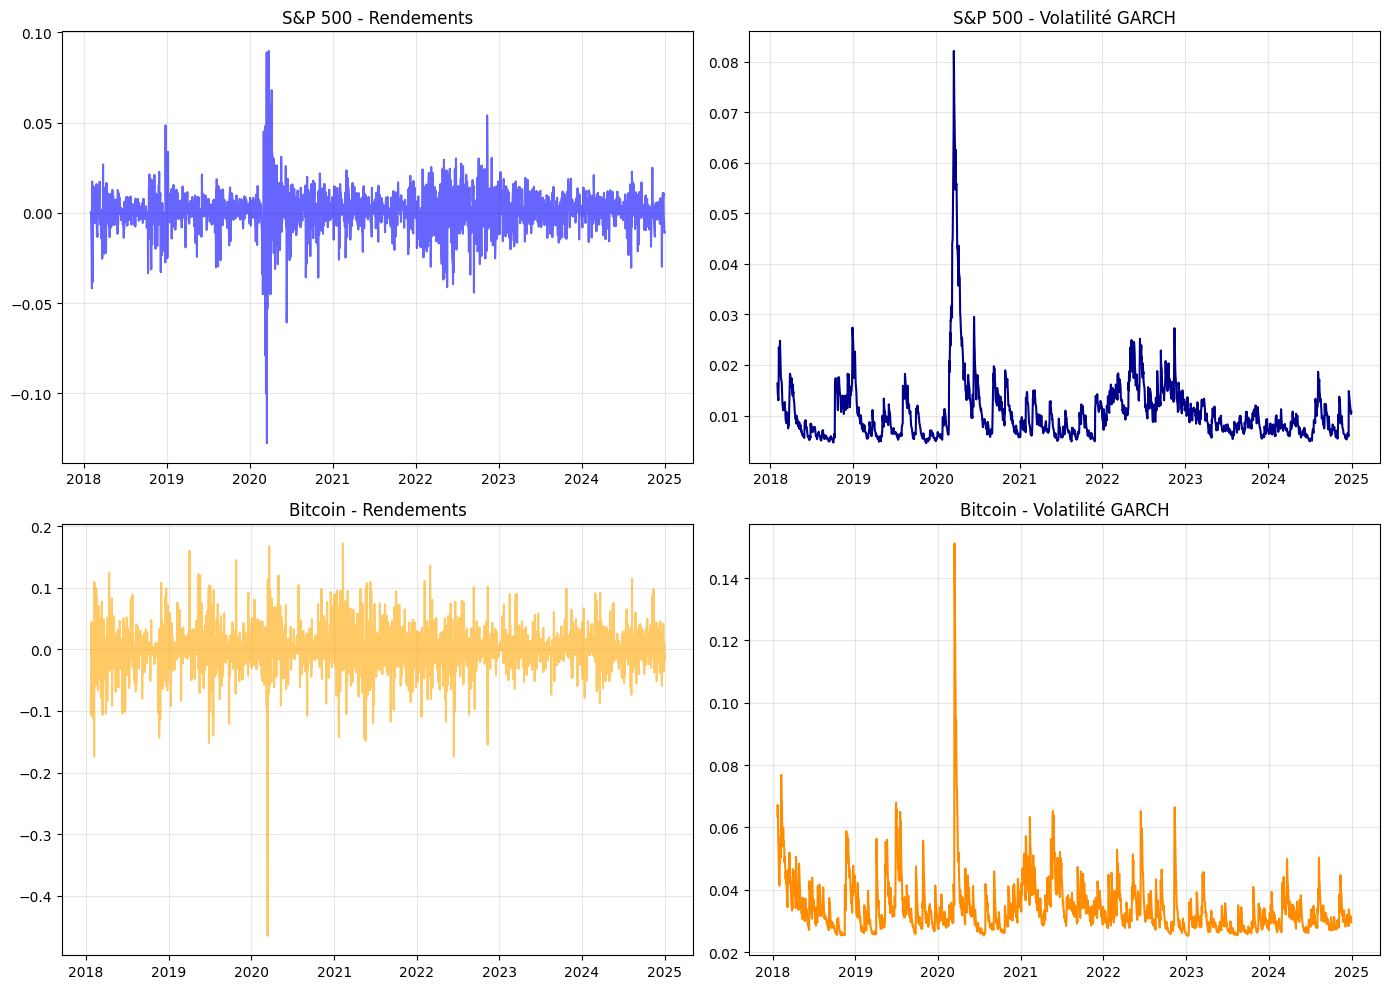

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# S&P 500 rendements
axes[0, 0].plot(spx_data['date'].iloc[1:], spx_returns, alpha=0.6, color='blue')
axes[0, 0].set_title('S&P 500 - Rendements')
axes[0, 0].grid(alpha=0.3)

# S&P 500 volatilité
axes[0, 1].plot(spx_data['date'].iloc[1:], vol_spx.values, linewidth=1.5, color='darkblue')
axes[0, 1].set_title('S&P 500 - Volatilité GARCH')
axes[0, 1].grid(alpha=0.3)

# Bitcoin rendements
axes[1, 0].plot(btc_data['date'].iloc[1:], btc_returns, alpha=0.6, color='orange')
axes[1, 0].set_title('Bitcoin - Rendements')
axes[1, 0].grid(alpha=0.3)

# Bitcoin volatilité
axes[1, 1].plot(btc_data['date'].iloc[1:], vol_btc.values, linewidth=1.5, color='darkorange')
axes[1, 1].set_title('Bitcoin - Volatilité GARCH')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/garch_volatility.png', dpi=300, bbox_inches='tight')
print("OK figure sauvegardée")
plt.show()